# Final

<font size=4>Brady Arendale, Pankaj Kumar, Kay Ayala  
8/12/20</font>

# Introduction

We have been asked to analyze a dataset containing a number of censored variables. We do not know what any of the data represents. The objective is to classify the response variable in a way that minimizes the cost to the business. We know that each false positive costs \\$10 and each false negative costs \\$500. True positives and true negatives cost nothing. We will use various statistical and machine learning techniques to attempt to solve this problem.

# Exploratory data analysis

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score
from sklearn.feature_selection import f_classif

In [2]:
data = pd.read_csv('final_project.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
x0     159974 non-null float64
x1     159975 non-null float64
x2     159962 non-null float64
x3     159963 non-null float64
x4     159974 non-null float64
x5     159963 non-null float64
x6     159974 non-null float64
x7     159973 non-null float64
x8     159979 non-null float64
x9     159970 non-null float64
x10    159957 non-null float64
x11    159970 non-null float64
x12    159964 non-null float64
x13    159969 non-null float64
x14    159966 non-null float64
x15    159965 non-null float64
x16    159974 non-null float64
x17    159973 non-null float64
x18    159960 non-null float64
x19    159965 non-null float64
x20    159962 non-null float64
x21    159971 non-null float64
x22    159973 non-null float64
x23    159953 non-null float64
x24    159972 non-null object
x25    159978 non-null float64
x26    159964 non-null float64
x27    159970 non-null float64
x28    159965 non-null

We have 160,000 observations. We have 50 explanatory variables, x0-x49, and one response variable, y. We have 45 numerical variables and 5 categorical variables. We have a number of missing values, so we need to use some imputation strategies to fill in our missing data. However, no variable has more than 50 missing values, so this should not make too large of an impact on our results.

First, let's take a look at our distribution of positive and negative classes.

In [4]:
print(data.y.value_counts())
print(data.y.value_counts(normalize=True))

0    95803
1    64197
Name: y, dtype: int64
0    0.598769
1    0.401231
Name: y, dtype: float64


We have 95,803 negative observations and 64,197 positive observations. Negative observations make up about 59.9% of the data, while positive observations make up about 40.1%. There is some class imbalance, but it is most likely not enough to affect our models.

Let's take a look at correlations between variables to get an idea of the relations present in our data.

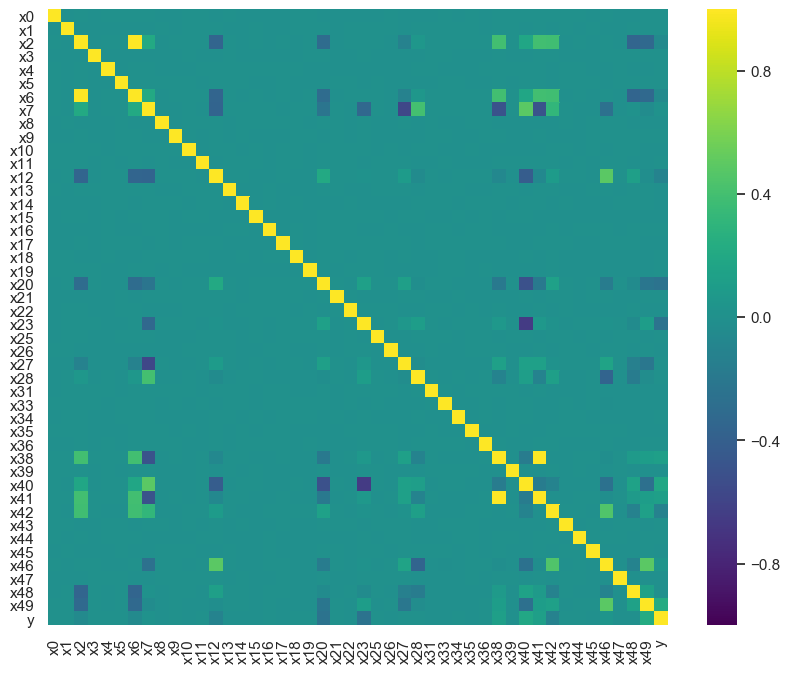

In [5]:
plt.style.use('default')
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(data.corr(), cmap='viridis', xticklabels=True,
            yticklabels=True, vmin=-1, vmax=1, ax=ax)
ax.set_xlim(0, 46)
ax.set_ylim(46, 0)
plt.show()

Most of our explanatory variables have very little correlation with each other. However, there are two pairs of variables that have extremely high correlation: x2 with x6, and x38 with x41. There are also some pairs of variables that have a high negative correlation, although not to the same extent as the two previous pairs.

Most variables have a very low, or even essentially zero, correlation with y. This suggests that many of these may not be useful in predicting y. We will have to either use models that can handle this themselves or use feature selection or dimensionality reduction to limit the number of variables that we pass into our models.

Let's take a look at the correlation between x2 and x6:

In [6]:
data.x2.corr(data.x6)

0.9999999999999987

And between x38 and x41:

In [7]:
data.x38.corr(data.x41)

0.9999999999999987

Both of these pairs of variables are essentially perfectly correlated. We can see this by plotting them against each other:

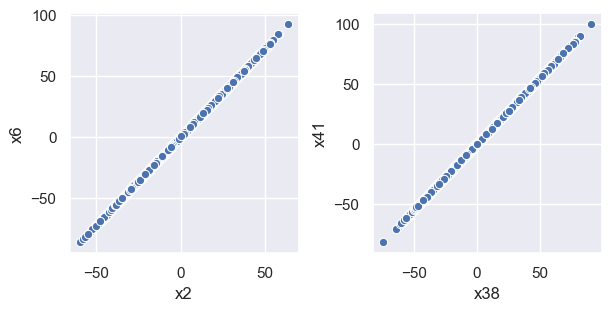

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
sns.scatterplot(data.x2, data.x6, ax=ax0)
sns.scatterplot(data.x38, data.x41, ax=ax1)
plt.show()

These variables have essentially a perfect linear relationship. This will likely pose a problem for any model that we put them into. We will solve this by dropping one column from each pair. It doesn't matter which, so we will just drop the second from each pair.

In [9]:
data.drop(columns=['x6','x41'], inplace=True)

Now let's take a look at some of our strong negative correlations:

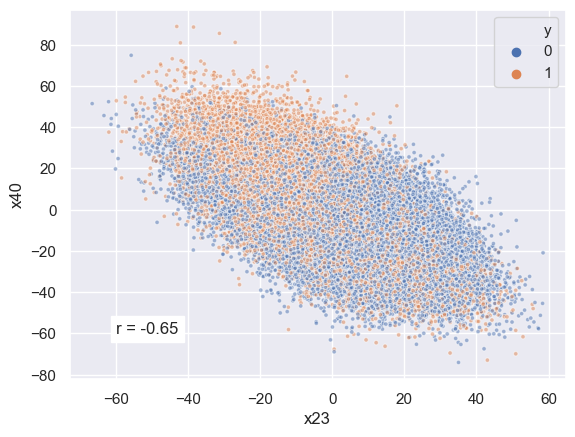

In [10]:
sns.scatterplot(data.x23, data.x40, hue=data.y, alpha=0.5, s=10)
plt.annotate("r = "+str(data.x23.corr(data.x40).round(2)), (-60,-60),
            backgroundcolor='white')
plt.show()

x23 and x40 have a strong negative correlation of -0.65. There might be a different distribution between positive and negative classes, but it is hard to tell with such a dense plot. Let's look at some comparisons:

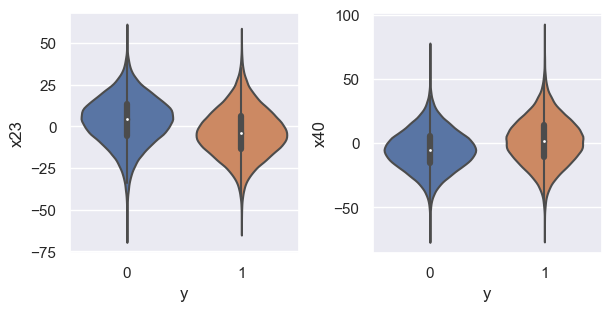

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
sns.violinplot(data.y, data.x23, ax=ax0)
sns.violinplot(data.y, data.x40, ax=ax1)
plt.show()

There appears to be a difference in distribution for each variable between the positive and negative classes. Both of these variables should be useful to our model.

Let's look at one more pair of variables:

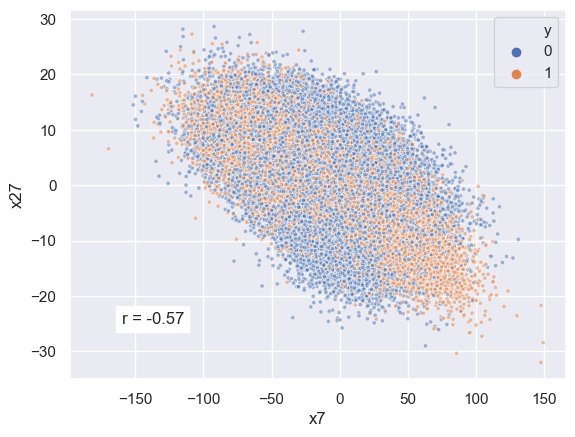

In [12]:
sns.scatterplot(data.x7, data.x27, hue=data.y, alpha=0.5, s=10)
plt.annotate("r = "+str(data.x7.corr(data.x27).round(2)), (-160,-25),
            backgroundcolor='white')
plt.show()

x7 and x27 have a moderate negative correlation. Again, there appears to be some separation between the positive and negative classes.

Let's look at some of our categorical variables now.

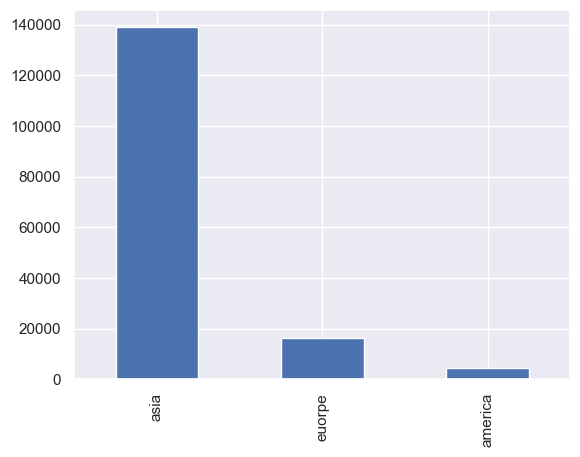

In [13]:
data.x24.value_counts().plot(kind='bar')
plt.show()

x24 appears to be related to continents. There is a much larger number of "asia" records than either "euorpe" or "america". "Europe" appears to be misspelled, but it is consistent, so it does not require any correction.

In [14]:
pd.crosstab(index=data.y, columns=data.x24, normalize='columns', margins=True)

x24,america,asia,euorpe,All
y,,,,
0,0.744686,0.591804,0.61791,0.598774
1,0.255314,0.408196,0.38209,0.401226


A cross-tabulation shows that "america" has a much higher than average percentage of negative classes. "asia" and "euorpe" are both close to average. This could help our models classify "america" records, but those only make up a small amount of our data.

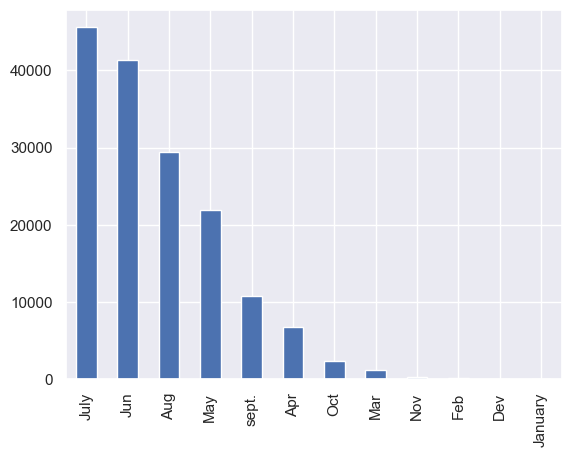

In [15]:
data.x29.value_counts().plot(kind='bar')
plt.show()

x29 appears to have month values. Months toward the middle of the year appear to have the most representation in our data. Some of them are misspelled or have different formatting, but these are consistent, so there is no need to correct them.

In [16]:
pd.crosstab(index=data.y, columns=data.x29, normalize='columns', margins=True)

x29,Apr,Aug,Dev,Feb,January,July,Jun,Mar,May,Nov,Oct,sept.,All
y,,,,,,,,,,,,,
0,0.594143,0.599129,0.521739,0.614286,0.666667,0.60065,0.599143,0.604387,0.595424,0.563798,0.589946,0.60024,0.598756
1,0.405857,0.400871,0.478261,0.385714,0.333333,0.39935,0.400857,0.395613,0.404576,0.436202,0.410054,0.39976,0.401244


A cross-tabulation shows that most of the categories have a class ratio very close to average. The ones with a ratio somewhat different from average, such as "Dev", "Feb", "January", and "Nov", have very little representation in the data, so these could just be different due to small sample sizes.

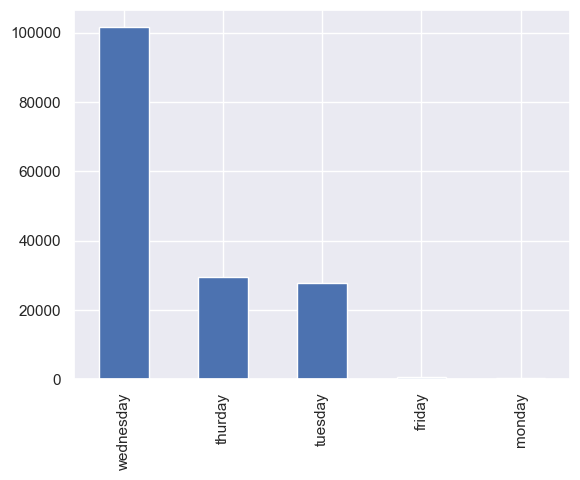

In [17]:
data.x30.value_counts().plot(kind='bar')
plt.show()

x30 appears to have information about days of the week. "wednesday" appears the most by far, with "friday" and "monday" having very few observations.

In [18]:
pd.crosstab(index=data.y, columns=data.x30, normalize='columns', margins=True)

x30,friday,monday,thurday,tuesday,wednesday,All
y,,,,,,
0,0.613475,0.60041,0.601991,0.600093,0.59742,0.598794
1,0.386525,0.39959,0.398009,0.399907,0.40258,0.401206


All of these categories have a class ratio very close to the average, so this variable is not likely to be useful for our models.

In [19]:
data.x32.value_counts()

0.01%     40767
-0.01%    34094
0.0%      33923
-0.0%     30492
-0.02%     9924
0.02%      7987
-0.03%     1727
0.03%       855
-0.04%      138
0.04%        55
-0.05%        6
0.05%         1
Name: x32, dtype: int64

x32 appears to be percents rather than actual categories. Let's convert it into a numerical variable.

In [20]:
data.x32 = data.x32.str.replace(pat='%', repl='')
data.x32 = data.x32.astype('float')

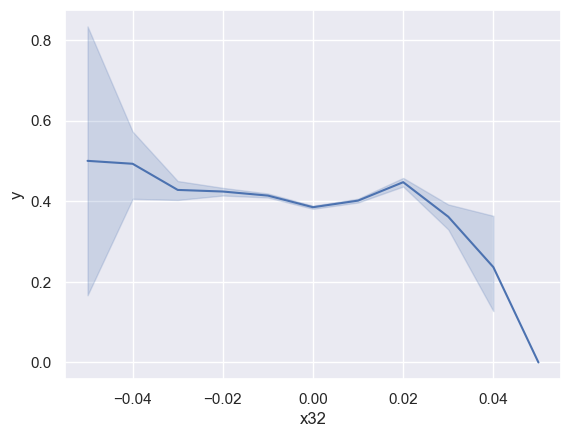

In [21]:
sns.lineplot(data.x32, data.y)
plt.show()

The percentage of positive classes appears to generally decrease for higher values of x32.

In [22]:
data.x37

0          $1313.96
1          $1962.78
2           $430.47
3         $-2366.29
4          $-620.66
            ...    
159995     $-891.96
159996     $1588.65
159997      $687.46
159998      $439.21
159999    $-1229.34
Name: x37, Length: 160000, dtype: object

x37 appears to be dollar amounts and again not an actual category. Let's convert it into a numerical variable.

In [23]:
data.x37 = data.x37.str.replace(pat='$', repl='')
data.x37 = data.x37.astype('float')

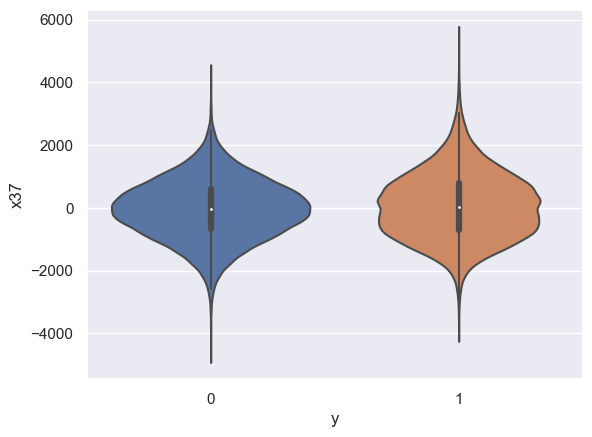

In [24]:
sns.violinplot(data.y, data.x37)
plt.show()

The positive class appears to be slightly more spread out than the negative class.

# Train-test split

We will split our data into an 80-20 train-test split. We will use a stratified split to ensure that both sets have an equal class ratio. Our training set will be used to fit our models, and we will then evaluate them on our test set to analyze their performance on unseen data.

In [25]:
y = data.pop('y')
X = data.copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9001)

In [27]:
X_train.shape

(128000, 48)

In [28]:
X_test.shape

(32000, 48)

Our training set has 128,000 observations, and our test set has 32,000 observations.

# Data imputation

We will now fill in our missing values. Let's look at the distribution of each variable in the training set to determine whether mean or median imputation is more appropriate.

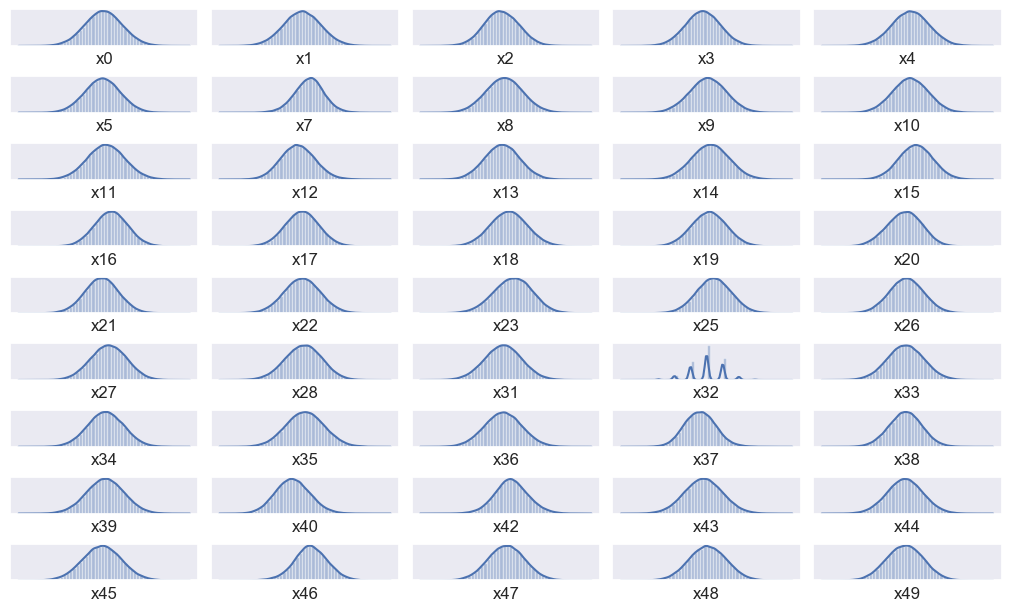

In [29]:
float_columns = X_train.columns[X_train.dtypes == 'float']

fig, axes = plt.subplots(9, 5, figsize=(10,6), constrained_layout=True)

for ax, col in zip(axes.flatten(), float_columns):
    sns.distplot(X_train[col].dropna(), ax=ax)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

We see that each variable is approximately normally distributed. Since the mean and median are equal for normal distributions, either one would be appropriate. The one exception is with x32, which is a discrete variable. Here the mean would give a result that doesn't exactly match one of the values, so the median would probably work better. We will impute the median for each of our numerical variables. For our categorical variables, we will impute the mode. We will impute both the training and test set using the medians and modes from only our training set to prevent data leakage.

In [30]:
categorical_columns = X_train.columns[data.dtypes == 'object']

for col in float_columns:
    impute_value = X_train[col].mean()
    X_train.loc[:,col] = X_train[col].fillna(value=impute_value)
    X_test.loc[:,col] = X_test[col].fillna(value=impute_value)

for col in categorical_columns:
    impute_value = X_train[col].mode().item()
    X_train.loc[:,col] = X_train[col].fillna(value=impute_value)
    X_test.loc[:,col] = X_test[col].fillna(value=impute_value)

F:\brady\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
F:\brady\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `item` has been deprecated and will be removed in a future version
  if __name__ == '__main__':


In [31]:
X_train.isna().sum().sum()

0

In [32]:
X_test.isna().sum().sum()

0

We no longer have any missing values in either our training set or test set.

# Data preprocessing

Before passing data into our models, we need to perform some preprocessing steps. First, we one-hot encode our categorical variables. This transforms our categorical columns into several numerical columns, which serve as indicator variables specifying if an observation falls into one category or not. This is necessary because most of our models cannot use categorical variables. The next step is to scale and center our data by subtracting the mean and dividing by the standard deviation for each column. This accounts for differences in scale between variables, which helps make our models well-behaved. We calculate the means and standard deviations of each column in the training set, and then use those values to standardize both the training set and test set. This ensures that our scaled values have the same meaning in both sets.

In [33]:
onehot = OneHotEncoder(handle_unknown='ignore')

col_transform = ColumnTransformer(
    transformers=[('OneHot', onehot, categorical_columns)],
    remainder='passthrough'
)

col_transform.fit(X_train)
X_train = col_transform.transform(X_train)
X_test = col_transform.transform(X_test)

In [34]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

We will now fit several models to our data. We will test several configurations for each model using a randomized grid search. We create a list of hyperparameter values that we want to search over, and the randomized grid search algorithm takes random combinations of those hyperparameter values and fits a certain number of models. This takes less computation time than an exhaustive grid search testing all possible combinations and performs nearly as well. We will use 5-fold stratified cross-validation to calculate a range of scores for each combination. This separates the data into 5 chunks with equal class balance and uses each chunk as a test set once while the model is trained on the other 4 chunks. Using this technique, we train 5 models for each hyperparameter combination to get a better estimate of out-of-sample error.

In scoring our models, we keep in mind the costs of both false positives and false negatives. We know that false negatives are much more costly than false positives. Since we know the precise cost associated with each, we implement this in a custom metric that we call the mean cost:
<p>
<center>$mean~cost = \frac{(-10*fp)+(-500*fn)}{tp+tn+fp+fn}$</center>

This tells us the expected cost per prediction of each model. A higher mean cost is better. The best possible value is \\$0 (classifying everything correctly), and the worst possible value is \\$-500 times the percent of actual positives plus \\$-10 times the percent of actual negatives (classifying everything incorrectly). We also evaluate our models using recall, defined as the ratio of true positives to true positives plus false negatives, to determine how many of the potentially-costly positives that we classified correctly.

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=9001)

In [36]:
def mean_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (-10*fp-500*fn)/len(y_true)

mean_cost_scorer = make_scorer(score_func=mean_cost)

## Elastic net logistic regression

Our first model is a penalized logistic regression model. We use a weighted average of L1 penalty, which adds the sum of the absolute values of the coefficients to the cost function, and L2 penalty, which adds the sum of the squares of the coefficients to the cost function. Using this penalty allows the model to perform implicit dimensionality reduction, since having higher coefficients for variables that do not contribute to explaining y results in a worse value of the cost function. This accounts for the fact that many of our variables do not have a strong correlation with y.

We test various hyperparameter combinations. We test L1 ratios (the ratio of L1 penalty to the total penalty) at various values from 0 to 1. We test values of C, the strength of the penalty parameter, at values spread logarithmically between 10^-4 and 10^4. We also use standard and balanced class weights. Balanced can account for the class imbalance in our dataset, while the standard class weights use the class weights present in the dataset.

In [37]:
log_params = {
    'l1_ratio': [0,0.05,0.1,0.3,0.5,0.7,0.9,0.95,1],
    'C': np.logspace(-4, 4, num=10),
    'class_weight': [None, 'balanced']
}

log_model = RandomizedSearchCV(
    LogisticRegression(penalty='elasticnet', solver='saga', 
                       max_iter=100, random_state=9001),
    param_distributions=log_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

log_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
F:\brady\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9001, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='elasticnet',
                                                random_state=9001,
                                                solver='saga', tol=0.0001,
                                                verbose=0, wa...
                   param_distributions={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+

In [38]:
log_model.best_params_

{'l1_ratio': 1, 'class_weight': 'balanced', 'C': 0.3593813663804626}

The best model chosen using our cross-validated randomized search has an L1 ratio of 1 (no L2 penalty), a C value of 0.36, and balanced class weights.

In [39]:
log_model.score(X_train, y_train)

-65.681171875

Our best model has a mean cost of $-65.68 on the training set.

In [40]:
log_pred = log_model.predict(X_train)
recall_score(y_train, log_pred)

0.6807313368900658

Our best model has a recall of 68% on the training set.

Once all of our models are trained, we will look at the test set mean cost and recall and compare between models.

## Random forest

Random forest creates an ensemble of decision trees. We test values of 10, 50, 100, and 200 for the number of trees to create for each model. We test both gini and entropy as our criterion for splitting leaf nodes. We test values 2, 5, and 10 for the minimum leaf size that can be split. We again test balanced and standard class weights.

In [41]:
rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

rf_model = RandomizedSearchCV(
    RandomForestClassifier(random_state=9001),
    param_distributions=rf_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9001, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight...
                                                    oob_score=False,
     

In [42]:
rf_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

We got our best results with 200 trees, a minimum samples split of 10, entropy criterion, and balanced class weights.

In [43]:
rf_model.score(X_train, y_train)

-0.6059375

Our best random forest model had a training mean cost of $-0.61. This is very low, but could indicate overfitting.

In [44]:
rf_pred = rf_model.predict(X_train)
recall_score(y_train, rf_pred)

0.9970403831924919

We got an extremely high recall score of 99.7%. High recall can be due to overfitting, or it could be a result of the model classifying almost everything as the positive class. Let's look at the confusion matrix to see which is the case.

In [45]:
confusion_matrix(y_train, rf_pred)

array([[76486,   156],
       [  152, 51206]], dtype=int64)

Our confusion matrix indicates a very high accuracy overall, with very few observations misclassified. We will look at test set metrics later to determine whether the random forest model overfit, and by how much.

## Naive Bayes

Naive Bayes uses conditional probabilities to calculate the probability of each class. There are no hyperparameters to tune, so we use it as is.

In [47]:
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [48]:
nb_pred = nb_model.predict(X_train)

mean_cost(y_train, nb_pred)

-85.7640625

Naive Bayes gives us a training mean cost of $-85.76.

In [49]:
recall_score(y_train, nb_pred)

0.5794423458857432

We got a recall score of 58%. Naive Bayes did not perform as well on the training set as the previous models, but this is not surprising since it is a relatively simple model.

## Dimensionality reduction

Some models are very sensitive to variables that do not contribute much to explaining the response variable y. Since we have many variables that had very low correlation with y, we will perform dimensionality reduction to reduce the number of features. We use an approach that performs an analysis of variance test between y and each of our explanatory variables. This indicates which variables have a statistically significant correlation. We select variables that have a siginficant p-value at the 0.05 significance level, after accounting for multiple comparisons.

In [50]:
col_names = np.append(col_transform.transformers_[0][1].get_feature_names(), float_columns)
pval = f_classif(X_train, y_train)[1]

In [51]:
significant_cols = np.where(pval < 0.05/65)[0]
col_names[significant_cols]

array(['x0_america', 'x0_asia', 'x0_euorpe', 'x2', 'x7', 'x12', 'x20',
       'x23', 'x37', 'x38', 'x40', 'x42', 'x46', 'x49'], dtype=object)

The variables selected line up fairly well with what we can see visually in the correlation heatmap. The tests concluded that the only significant categorical variable was x24, the one that appeared to be related to continents. This matches what we saw in the cross-tabulations, where the only variables that were much different from average were those with very low counts.

In [52]:
X_train_subset = X_train[:,significant_cols]
X_test_subset = X_test[:,significant_cols]

## K-nearest neighbors

K-nearest neighbors calculates the distance between an observation in the test set and each observation in the training set. It then chooses the k nearest observations in the training set, counts the number of each class in those observations, and chooses the class with the highest count as the classification. It is a computationally expensive algorithm and is sensitive to variables that have low correlation with the response variable, so we use our dimensionality reduced subset to train it.

We test k values of 3, 5, 7, and 9 nearest neighbors. We test uniform and distance-based weights, which controls how much contribution each neighbor has based on how close it is to the test observation. We test Euclidean distance and Manhattan distance, which provide different calculations of closeness.

In [53]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=knn_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=2
)

knn_model.fit(X_train_subset, y_train)

F:\brady\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9001, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=20, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7, 9],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=9001, refit=True,
                   return_train_score=False, scoring=make_scorer(mean_cost),
          

In [54]:
knn_model.best_params_

{'weights': 'distance', 'n_neighbors': 5, 'metric': 'euclidean'}

We achieve the best results using 5 neighbors, distance-based weights, and Euclidean distance.

In [55]:
%time knn_pred = knn_model.predict(X_train_subset)

mean_cost(y_train, knn_pred)

Wall time: 50.7 s


0.0

K-NN classified the training set perfectly, resulting in a mean cost of $0. This is most likely due to overfitting.

In [56]:
recall_score(y_train, knn_pred)

1.0

We also see a perfect recall score of 100% on the training set.

In [57]:
confusion_matrix(y_train, knn_pred)

array([[76642,     0],
       [    0, 51358]], dtype=int64)

Looking at the confusion matrix confirms that the K-NN model perfectly classified the training set. Since this is most likely overfitting, we will look at the test set metrics later to evaluate the true performance of the K-NN model.

## Support vector machine

Support vector machines (SVM) attempt to draw a hyperplane through the data to split the data into classes as accurately as possible. SVM utilizes a technique called the kernel trick to project data into higher dimensions in order to make it linearly separable when it might not be otherwise. SVM is a computationally expensive algorithm like K-NN, so we train it on our dimensionality reduced subset.

Since SVMs take so long to train, we only test one configuration. We use the default configuration, which uses the RBF kernel.

In [61]:
svm_model_rbf = SVC(verbose=True)

%time svm_model_rbf.fit(X_train_subset, y_train)

[LibSVM]Wall time: 3min 16s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=True)

In [63]:
%time svm_rbf_pred = svm_model_rbf.predict(X_train_subset)

mean_cost(y_train, svm_rbf_pred)

Wall time: 1min 28s


-20.063515625

Our SVM model achieved a training set mean cost of $-20.06.

In [64]:
recall_score(y_train, svm_rbf_pred)

0.9015148564975272

We get a very high recall score of 90%. We will look into the test set metrics later to see if this is a result of overfitting, or if it generalizes well to the test set.

## Naive Bayes with dimensionality reduction

Since our models with dimensionality reduction have worked well so far, we'd like to test our previous models with the dimensionality reduced subset as well. We'll start with Naive Bayes since it trains very quickly. This will give us an idea of if we should proceed with the other models or if it doesn't improve performance.

In [66]:
nb_model_dr = GaussianNB()

nb_model_dr.fit(X_train_subset, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [68]:
nb_dr_pred = nb_model_dr.predict(X_train_subset)

mean_cost(y_train, nb_dr_pred)

-78.662421875

Naive Bayes with dimensionality reduction resulted in a training mean cost of \\$-78.66, compared to our full set model's mean cost of \\$-85.76. This is a substantial improvement, so we will proceed with our other models.

In [69]:
recall_score(y_train, nb_dr_pred)

0.6155613536352662

Naive Bayes with dimensionality reduction resulted in a recall score of 62%, compared to the earlier score of 58%.

## Elastic net with dimensionality reduction

We will fit our elastic net logistic regression models with the same hyperparameters as before. Since elastic net is a penalized model and performs implicit feature reduction, we do not expect the same level of improvement as we got with Naive Bayes.

In [70]:
log_model_dr = RandomizedSearchCV(
    LogisticRegression(penalty='elasticnet', solver='saga', 
                       max_iter=100, random_state=9001),
    param_distributions=log_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

log_model_dr.fit(X_train_subset, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.7s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9001, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='elasticnet',
                                                random_state=9001,
                                                solver='saga', tol=0.0001,
                                                verbose=0, wa...
                   param_distributions={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+

In [72]:
log_model_dr.best_params_

{'l1_ratio': 0, 'class_weight': 'balanced', 'C': 21.54434690031882}

Our best parameters this time were an L1 ratio of 0 (only L2 penalty), class weight balanced, and a C value of 21.5. This is very different from our earlier model, which had an L1 ratio of 1 and a much lower value of C.

In [71]:
log_model_dr.score(X_train_subset, y_train)

-65.60578125

Our elastic net model this time performed only slightly better with a mean cost of $-65.61, an improvement of 7 cents.

In [74]:
log_dr_pred = log_model_dr.predict(X_train_subset)

recall_score(y_train, log_dr_pred)

0.6811207601542116

Our new elastic net model got approximately the same recall score as before.

We achieved very little performance gain, but the model did train much faster on the reduced subset. We will see later if these models achieve the same level of generalization to the test set.

## Random forest with dimensionality reduction

Random forest also performs a certain degree of implicit feature selection. It chooses a random subset of features to use for each tree, and the trees with the better subset of features naturally perform better. Thus, we do not expect as large gains as Naive Bayes, but still possibly larger than elastic net logistic regression. We use the same hyperparameters as before for our randomized search.

In [75]:
rf_model_dr = RandomizedSearchCV(
    RandomForestClassifier(random_state=9001),
    param_distributions=rf_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

rf_model_dr.fit(X_train_subset, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9001, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight...
                                                    oob_score=False,
     

In [76]:
rf_model_dr.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

Our best hyperparameters for the random forest with dimensionality reduction are the same as the full set random forest model.

In [78]:
rf_model_dr.score(X_train_subset, y_train)

-1.894140625

The training mean cost score was $-1.89, worse than the full set model. However, the full set model likely overfit, so this may not necessarily indicate that the model generalizes worse.

In [79]:
rf_dr_pred = rf_model_dr.predict(X_train_subset)

recall_score(y_train, rf_dr_pred)

0.9907511974765373

We get a slightly worse recall of 99.1%, 0.6% lower than the full set. We will look at the test set metrics to see which model generalizes better to the test set.

# Model comparison

With all of our models trained, we will now calculate the mean cost and recall scores of each model for the test set.

In [82]:
models_no_dr = [
    ('Elastic net logistic regression', log_model),
    ('Random forest', rf_model),
    ('Naive Bayes', nb_model)
]

models_dr = [
    ('Elastic net w/ dimensionality reduction', log_model_dr),
    ('Random forest w/ dimensionality reduction', rf_model_dr),
    ('Naive Bayes w/ dimensionality reduction', nb_model_dr),
    ('K-nearest neighbors', knn_model),
    ('SVM', svm_model_rbf)
]

In [84]:
for (name, model) in models_no_dr:
    y_pred = model.predict(X_test)
    print(name+":")
    print("\tMean cost:", mean_cost(y_test, y_pred))
    print("\tRecall:", recall_score(y_test, y_pred))

for (name, model) in models_dr:
    y_pred = model.predict(X_test_subset)
    print(name+":")
    print("\tMean cost:", mean_cost(y_test, y_pred))
    print("\tRecall:", recall_score(y_test, y_pred))

Elastic net logistic regression:
	Mean cost: -65.0365625
	Recall: 0.6840096580730587
Random forest:
	Mean cost: -21.7
	Recall: 0.8932938702391152
Naive Bayes:
	Mean cost: -87.81625
	Recall: 0.569436872030532
Elastic net w/ dimensionality reduction:
	Mean cost: -65.340625
	Recall: 0.6825297920398785
Random forest w/ dimensionality reduction:
	Mean cost: -25.9084375
	Recall: 0.8727315211465068
Naive Bayes w/ dimensionality reduction:
	Mean cost: -79.780625
	Recall: 0.6101721317859646
K-nearest neighbors:
	Mean cost: -21.5303125
	Recall: 0.8943064101565542
SVM:
	Mean cost: -20.4203125
	Recall: 0.8997585481735337


Model | Mean cost | Recall
--- | --- | ---
Elastic net (no DR) | \$-65.04 | 68.4%
Elastic net (w/ DR) | \$-65.34 | 68.3%
Random forest (no DR) | \$-21.70 | 89.3%
Random forest (w/ DR) | \$-25.91 | 87.3%
Naive Bayes (no DR) | \$-87.82 | 56.9%
Naive Bayes (w/ DR) | \$-79.78 | 61.0%
K-nearest neighbors | \$-21.53 | 89.4%
SVM | **$-20.42** | **90.0%**

The best-performing model was SVM, with a mean cost of \\$-20.42 and a recall of 90.0\%. This was closely followed by K-nearest neighbors and random forest with no dimensionality reduction. The worst performing model by far was Naive Bayes both with and without dimensionality reduction, with elastic net logistic regression also performing poorly. Elastic net and random forest both performed better without dimensionality reduction. Since they perform feature selection implicitly, they might have learned some pattern in the data using features not present in the dimensionality-reduced set, without being hindered by the variables that did not contribute anything. Naive Bayes does not have any sort of feature selection, and the features that contributed nothing were likely somewhat drowning out the features that did contribute. K-nearest neighbors and SVM were not tested without dimensionality reduction due to the long training times required, but would likely have performed worse without it due to their nature.

In [88]:
confusion_matrix(y_test, y_pred)

array([[18166,   995],
       [ 1287, 11552]], dtype=int64)

Our SVM model incorrectly predicts 1287 positive observations to be negative and 995 negative observations to be positive. A more optimal model might predict more false positives than false negatives, but this may not be feasible due to the nature of the data. Regardless, this result is still very strong.

# Conclusion

We found that the dataset had many normally-distributed variables, most of which had very little correlation with each other or with the response variable. However, we did find two pairs of variables that were perfectly correlated, and deleted one variable from each pair. We examined some of the correlations between variables and the response, and noted a few that appeared to have some impact on the response and some that didn't. We found two instances of categorical variables actually being numerical variables and corrected them.

We used an 80-20 training-test split so that we could have a holdout set to test the performance of our models on unseen data. We noted that every numerical variable was approximately Gaussian, and used median imputation to fill in the missing values. We also used mode imputation to fill in missing values for our categorical variables. We performed one-hot encoding so that we could use our categorical variables in our models. We standardized each variable in order for our models to be well-behaved, which especially important for distance-based models like K-nearest neighbors but not important for tree-based models like random forest.

We trained several models to predict the class of our response variable, and evaluated them using mean cost and recall. We performed a randomized search over a variety of hyperparameter combinations for the best configuration for each model using 5-fold cross-validation. This gave us the optimal performance for each model, while also giving us better estimates of out-of-sample error. We used a feature selection technique based on analysis of variance, which measures each variable's individual contribution to the repsonse variable, only selecting those that are statistically significant. We trained some models with both the full set and the dimensionality-reduced set, and some others only on the dimensionality-reduced set, based on training time and performance expectations. We found that random forest and K-nearest neighbors overfit the training data, but still performed well on the test set. The best model overall was SVM, which gave the best mean cost and recall, while also not overfitting.

With the SVM model, we expect the business to lose \\$20.42 for each prediction compared to a baseline of \\$0, which we believe to be a very strong result. The model classifies 90% of positive class observations correctly. We believe this model can be very useful to the business in mitigating costs.